# How To Use Sampling in Real-World Machine Learning to Significantly Improve Model Performance

## How and when to use sampling in a machine learning project to ensure that predictions are accurate and meaningful

### Background
In a recent machine learning project I was involved in the model looked to be performing well against validation data and was considered ready to be moved into the production environment.

The problem came when the overall ration of predictions on the production dataset looked outlandish and the domain experts fed back that this must be wrong.

This article sets out to explore the issue and how sampling was used to deliver a model that could be used in the production environment with confidence.

### Getting Started
Lets start by importing and initialising the libraries that are needed in the project ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import Tuple

from sklearn.model_selection import train_test_split
from shap import Explainer, plots, initjs
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

initjs() 

### Importing and Preparing the Data
The next block of code reads in the data. The data represents a set of customer loans that can be classified into "Repaid" where the customer repays the full amount or "Defaulted" where the customer fails to repay the loan. Where the loan status is null the loan is still in progress and is yet to complete.

Please note that the dataset is entirely fictitious and has been built by the author using the ``Faker`` library to illustrate the problem that was encountered in a real-world machine learning project. 

This means that there are no license restrictions on the data and it can be used freely in other projects for testing and learning purposes.

If you would like to know more about ``Faker`` here is a link to the library - https://faker.readthedocs.io/en/master/.

In [26]:
df_loans = pd.read_excel("Data/CustomerLoansNewv2.xlsx", index_col="CustomerNumber") # Read in the data ...

# One hot encode the categorical columns and remove any special characters from the column names to resolve "LightGBMError: Do not support special JSON characters in feature name." error ...
df_loans = pd.concat([pd.get_dummies(df_loans, columns=["CustomerGender", "CustomerAccessedAdvice", "CustomerJobTitle", "CustomerDepartment", "EmployerName", "EmployerBusinessActivity", "LoanApplicationMethod", "LoanType"]), df_loans["LoanType"]], axis=1)
df_loans.rename(columns = lambda x:re.sub('[^A-Za-z0-9-]+', '', x), inplace=True) 

In [27]:
df_loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5286 entries, 29061 to 12345
Data columns (total 2168 columns):
 #     Column                                                   Dtype         
---    ------                                                   -----         
 0     CustomerAgeAtStart                                       int64         
 1     CustomerDeprivationDecile                                float64       
 2     CustomerIncomeDecile                                     float64       
 3     CustomerEmploymentDecile                                 float64       
 4     CustomerEducationandSkillsDecile                         float64       
 5     CustomerCrimeDecile                                      float64       
 6     EmployerNumberOfEmployees                                int64         
 7     LoanExpectedEndDate                                      datetime64[ns]
 8     LoanStatus                                               object        
 9     CustomerGe

The next code block split the loans data into completed (with status "Repaid" or "Defaulted") and live (which do not have a status yet as they have not yet completed) and then further splits the completed loans into a training and testing set.

In [28]:
completed_filter = df_loans["LoanStatus"].isin(["Repaid", "Defaulted"])
df_completed = df_loans[completed_filter].copy(deep=True)
df_live = df_loans[~completed_filter].copy(deep=True)

X = df_completed.drop(["LoanStatus", "LoanType", "LoanExpectedEndDate"], axis=1)
y = df_completed["LoanStatus"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
print(X_train.shape, X_test.shape)

(3134, 2165) (1045, 2165)


### Building a Machine Learning Model
The next stage is to train a model based on the training data and to use it to make predictions for the test data which can be evaluated for accuracy and to make predictions for the live data which cannot be evaluated using traditional metrics as the outcome is not yet known.

In [29]:
# Fit a LightGBM classifier using the training data
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Make a set of predictions for the test data and show the accuracy
y_test_pred = model.predict(X_test)
print(f"Accuracy score of the model for the testing data: {accuracy_score(y_test, y_test_pred):.1%}")

Accuracy score of the model for the testing data: 72.2%


### Evaluating Overall Performance
We cannot know the accuracy of the model against the live / production data as those loans will not have a classification label until they complete, but there are other ways that performance can at least be hinted at.

For example, lets take a look at the overall ratio of defaulted and repaid for all the loans that have already completed.

In [30]:
df_completed["LoanStatus"].value_counts(normalize=True).sort_index()

Defaulted    0.347452
Repaid       0.652548
Name: LoanStatus, dtype: float64

So 34.8% of loans default and 65.2% of loans repay.

Now lets take a look at the overall ratio for the predictions on the test data.

In [31]:
pd.Series(y_test_pred).value_counts(normalize=True).sort_index()

Defaulted    0.242105
Repaid       0.757895
dtype: float64

The model predicts 23.8% defaulting and 76.2% repaying in the test data. The ratio of defaults in the test data is lower than the overall ratio but it is not totally outlandish so the model might be performing OK.

Now lets take a look at the overall ratio for predictions against the loans that are currently live and active.

In [33]:
y_live_pred = model.predict(df_live.drop(["LoanStatus", "LoanType", "LoanExpectedEndDate"], axis=1))
pd.Series(y_live_pred).value_counts(normalize=True).sort_index()

Defaulted    0.699187
Repaid       0.300813
dtype: float64

The model is predicting a 76.1% overall ratio of defaults which is very different from 34.8% for all historic loans and 23.8% for the test data!

Sure enough when we check with our domain users (who do not exist remember as this is fictitious data!) they report back that from their observation and experience they expect the defaults on future loans to broadly outturn in a similar way to historic loans.

At this point we appear to have a big problem. Our machine learning model is predicting overall ratios that the domain users do not recognise and cannot accept.

So what is happening? Is there a massive flaw in our model causing it to be overly pessimistic? Are the domain users wrong and the loan paerformance is about to drop off a cliff? Or could it be something else entirely?

This is the problem I was facing in my real world project (albeit on completely different data with actual real-world domain experts!).

The rest of this article describes how I used data stratification in the solution I came up with to build a model that could be used with confidence by the  users to deliver impact and outcomes in their business domain.

### Explaining the Model
The first step in finding a solution was to build a much better understnading of how the model was making its predictions and I have found the SHAP library to be a great way to do this.

If you would like to know more about the SHAP library, here is a link to the documentation - https://shap.readthedocs.io/en/latest/index.html.

When building machine learning models data scientists face a dilemma. We can build models using advanced techniques including stacking and voting or we can try to scale data or artificially engineer features all of which may drive small improvements in performance.

However, every time we take a towards complexity and data obscurity we take a step away from model explainability and in the real world we need to make a conscious desicion about which of these is more improtant in the business context of the project we are working on.

In the real-world project and in the example presented here I have made the assumption that being able to understand the predictions is more important. This has shaped the way I built the model inb the code above and it enables the use of the SHAP model to visualise how the predictions are being made.

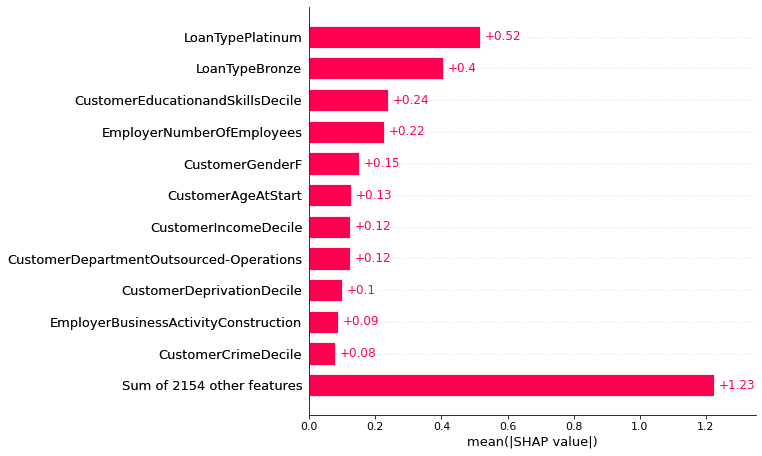

In [34]:
explainer = Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)

plots.bar(shap_values, max_display=12)

The code above uses the machine learning model coupled with the training data to explain what is happening within the test data. I have seen many examples online that miss the point about explaining the test data but this is the correct way to visualise what is going on.

What this means is that ``LoanTypePlatinum`` is the feature that adds the biggest weight to the model prediction, followed by ``LoanTypeBronze`` in 2nd place and ``EmployerNumberOfEmployees`` in 3rd place.

We can also use shap to take a look at how a prediction was made for an individual customer ...

Repaid


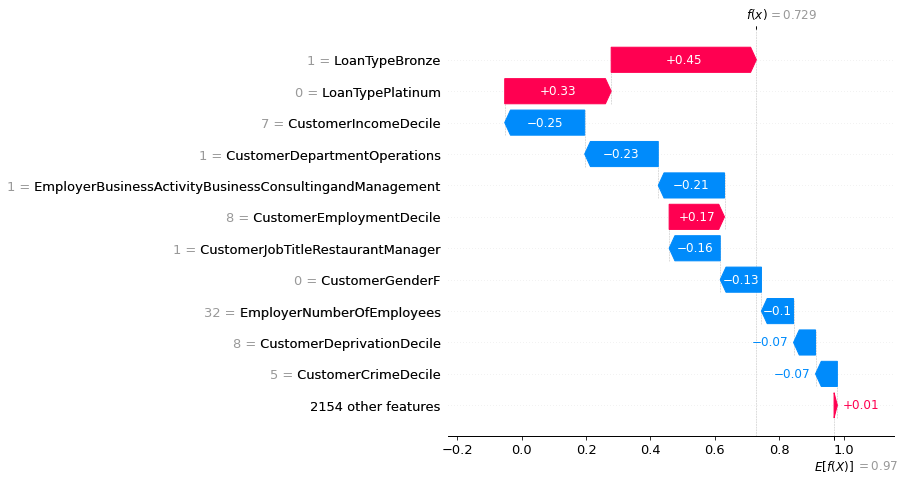

In [36]:
print(y_test_pred[0])
plots.waterfall(shap_values[0], max_display=12) 

Here we are looking at the explanation for the 1st row of test data (with index 0). We can see that the model prediction was for "Defaulted" and that ``LoanTypePlatinum`` had the biggest impact on that prediction.

Repaid


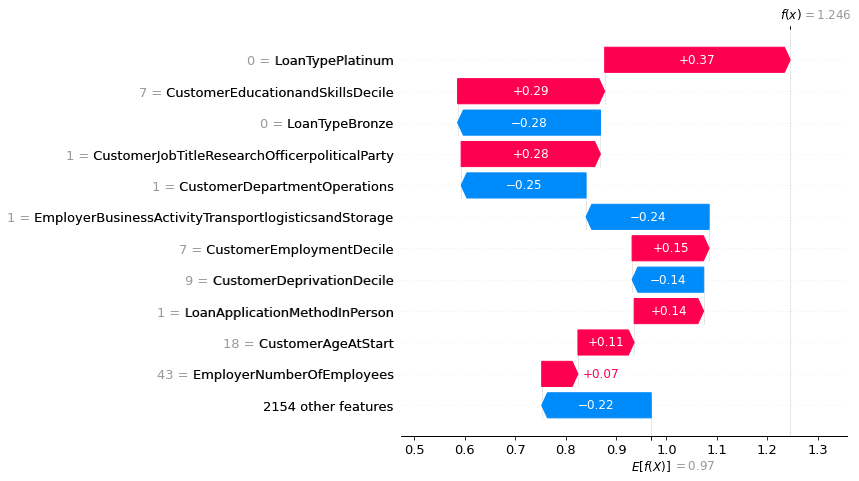

In [37]:
print(y_test_pred[1])
plots.waterfall(shap_values[1], max_display=12) 

The next record (with index 1) had a prediction of "Repaid" and we can see that ``LoanTypeBronze`` is the most significant factor in this prediction. 

It is beginning to look like "Platinum" loans are more likely to lead to a prediction of "Default" and "Bronze" loans to a prediction of "Repaid".

Armed with this knowledge we now need to go back to our (still fictitious!) domain experts to explore why "Platimum" loans look to be defaulting and what the reasons might be.

### Eureka! Understanding the Problem!
Our non-existent domain experts think they can spot the problem. It transpires that "Platinum" loans have only recently been introduced and that over a period of time all bronze, silver and gold loans are being phased out so there will only be "Platinum" loans moving forward.

Furthermore the business is currently in the middle of the transition period. The domain experts suspect that most of the "Platinum" loans have not existed long enough to complete the repayment term and they are either defaulted or on-going.

Let's take a quick look at the data to test this theory out.

In [38]:
df_loans[completed_filter]["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3} ))

Bronze      0.413735
Silver      0.216559
Gold        0.144293
Platinum    0.225413
Name: LoanType, dtype: float64

This tells us that the completed loans are 41% Bronze, 22% Silver, 14% Gold and 23% Platinum.

Now lets have a look at the live loans ...

In [39]:
df_loans[~completed_filter]["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}))

Bronze      0.014453
Silver      0.025294
Gold        0.011743
Platinum    0.948509
Name: LoanType, dtype: float64

They are 95% "Platinum", so this bears out what the domain experts are telling us. Now lets the second part of the theory - that the "Platinum" loans are too new to have finished (repaid) yet in significant numbers -

In [40]:
old_loans_filter = df_loans["LoanType"].isin(["Bronze", "Silver", "Gold"])

df_loans[old_loans_filter]["LoanStatus"].fillna("Live").value_counts(normalize=True)

Repaid       0.717668
Defaulted    0.265027
Live         0.017304
Name: LoanStatus, dtype: float64

In [41]:
df_loans[~old_loans_filter]["LoanStatus"].fillna("Live").value_counts(normalize=True)

Live         0.527108
Defaulted    0.290663
Repaid       0.182229
Name: LoanStatus, dtype: float64

This provides a good verification for the domain experts theory. Most of the "Platinum" loans are too new to have completed yet. A large proportion of those that have completed have done so because they have defaulted before the loan term is up and this is skewing our machine learning model to associate "Platinum" loans with defaulting even though this may not be true in future.

### Eureka Mk II! Fixing the Problem
In the real world problem I came up with this approach as a potential solution: I would stratify the training data to contain the same proportion of "Platinum" loans as the future data. In theory this should remove the platinum type as the most significant feature in the model predictions and use other features instead. Also this would provide training data that is a much better fit to what the future production data is going to look like.

What we need now is a function that stratifies one ``DataFrame`` based on the proportions found in another.

In [42]:
def stratify(sample : pd.DataFrame, population : pd.DataFrame, stratify_cols : list, random_state : int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    weights = (population[stratify_cols].value_counts(normalize=True) * sample.shape[0]).astype(int)

    df_return = sample.groupby(stratify_cols).apply(lambda group: group.sample(n=weights[group.name] if group.name in weights else 0, replace=True, random_state=random_state))
    df_return.index = df_return.index.droplevel(level=stratify_cols)
    
    return df_return, weights

In [ ]:
#df_completed = df_loans_encoded[completed_filter].copy(deep=True)

In [45]:
#df_completed["LoanType"] = df_loans[completed_filter]["LoanType"]
#df_live["LoanType"] = df_loans[~completed_filter]["LoanType"]

end_date_filter = df_completed["LoanExpectedEndDate"] <= pd.to_datetime("30/04/2022", format=r"%d/%m/%Y")

df_completed_stratified, weights = stratify(sample=df_completed[end_date_filter], population=df_live, stratify_cols=["LoanType"], random_state=42)

df_completed_stratified["LoanType"].value_counts(normalize=True)#.sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}))

Platinum    0.948789
Silver      0.025227
Bronze      0.014379
Gold        0.011604
Name: LoanType, dtype: float64

In [46]:
X = df_completed_stratified.drop(["LoanStatus", "LoanType", "LoanExpectedEndDate"], axis=1)
y = df_completed_stratified["LoanStatus"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
print(X_train.shape, X_test.shape)

(2973, 2165) (991, 2165)


So now we have a set of training data that stratifies the ``LoanType`` in such a way that it is representative of the future, production data. Lets take a look and see if it has worked ...

In [47]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Make a set of predictions for the test data and show the accuracy
y_test_pred = model.predict(X_test)
print(f"Accuracy score of the model for the testing data: {accuracy_score(y_test, y_test_pred):.1%}")

Accuracy score of the model for the testing data: 94.9%


In [48]:
pd.Series(y_test_pred).value_counts(normalize=True).sort_index()

Defaulted    0.485368
Repaid       0.514632
dtype: float64

In [49]:
df_completed["LoanStatus"].value_counts(normalize=True).sort_index()

Defaulted    0.347452
Repaid       0.652548
Name: LoanStatus, dtype: float64